In [6]:
import wandb
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

In [7]:
# --- HELPER FUNCTION ---
def process_single_run(run):
    try:
        # Skip if not finished to save time
        if run.state != "finished":
            return None

        # 1. Extract Config
        try:
            opt_args = run.config.get("optimizer_params", {}).get("args", {})
            safety_factor = opt_args.get("polar_safety")
        except Exception:
            safety_factor = None

        # 2. Download History
        # scan_history handles pagination to prevent 500 Errors
        history_generator = run.scan_history()
        history_list = [row for row in history_generator]

        if not history_list:
            return None

        # 3. Build DataFrame
        df = pd.DataFrame(history_list)

        # 4. Add Metadata
        df["run_id"] = run.id
        df["run_name"] = run.name
        df["sweep_id"] = run.sweep.id if run.sweep else "no_sweep"
        df["safety_factor"] = safety_factor

        return df

    except Exception as e:
        return None

# --- 1. ROBUST LOADER ---
def load_data(filepath="./data/master_project_data.csv"):
    """
    Loads the CSV with low_memory=False to handle mixed types
    (fixing the DtypeWarning) and parses known numeric columns.
    """
    print(f"Loading {filepath}...")
    # low_memory=False forces pandas to read the whole file to determine dtypes
    # instead of guessing chunk-by-chunk.
    df = pd.read_csv(filepath, low_memory=False)
    print(f"Loaded {len(df)} rows. Columns found: {len(df.columns)}")
    return df

# --- 2. FAST PLOTTER ---
def plot_fast(df, x_col, y_col, hue_col=None, title=None, log_scale=False):
    """
    Wrapper for Seaborn lineplot.
    """
    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=hue_col,
        errorbar="sd" # Shows Standard Deviation shadow
    )

    if log_scale:
        plt.yscale("log")

    if title:
        plt.title(title)
    else:
        plt.title(f"{y_col} vs {x_col}")

    plt.grid(True, alpha=0.3)
    plt.show()

# --- 3. THE DEBUGGER (Why your plot failed) ---
def find_col(df, keyword):
    """Prints all columns containing the keyword (e.g., 'loss')"""
    matches = [c for c in df.columns if keyword in str(c).lower()]
    print(f"Columns matching '{keyword}':")
    print(matches)


# --- HELPER: FLATTEN CONFIG ---
def flatten_config(config):
    """Flattens nested W&B config dictionary."""
    out = {}
    for key, value in config.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                out[f"config_{key}.{sub_key}"] = sub_value
        else:
            out[f"config_{key}"] = value
    return out

# --- HELPER: PROCESS SINGLE RUN METADATA ---
def process_run_metadata(run):
    """Extracts metadata for the manifest. Fast operation."""
    try:
        if run.state != "finished":
            return None

        # Get Sweep ID safely
        sweep_id = run.sweep.id if run.sweep else "manual_runs"

        # Build Manifest Row
        meta = {
            "run_id": run.id,
            "run_name": run.name,
            "sweep_id": sweep_id,
            "state": run.state,
            "created_at": run.created_at
        }

        # Merge config
        meta.update(flatten_config(run.config))

        # Return tuple: (sweep_id, run_object, meta_dict)
        # We return the run object so we can group them later without re-fetching
        return (sweep_id, run, meta)

    except Exception as e:
        return None

# --- HELPER: DOWNLOAD HISTORY (From previous step) ---
def download_run_history(run):
    try:
        history_gen = run.scan_history()
        history_list = [row for row in history_gen]
        if not history_list:
            return None
        df = pd.DataFrame(history_list)
        df["run_id"] = run.id
        return df
    except:
        return None

In [8]:
# --- CONFIGURATION ---
ENTITY = "justin_yang-university-of-california-berkeley"
PROJECT = "cs182-project-GPT-opt"
DATA_DIR = "./data"
SWEEPS_DIR = os.path.join(DATA_DIR, "sweeps")
MANIFEST_FILE = os.path.join(DATA_DIR, "runs_manifest.csv")
MAX_WORKERS = 64  # Download 64 runs at once (Safe for W&B API limits)

In [9]:
# 1. Setup
os.makedirs(SWEEPS_DIR, exist_ok=True)
api = wandb.Api(timeout=60)

print(f"Fetching run list from {ENTITY}/{PROJECT}...")
# This just gets the iterator, doesn't download details yet
runs = api.runs(f"{ENTITY}/{PROJECT}")

# 2. Parallel Manifest Build
print(f"Building Manifest with {MAX_WORKERS} workers...")

manifest_data = []
runs_by_sweep = {}

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit all runs to the pool
    # Note: We cast runs to list to force the initial pagination fetch
    futures = [executor.submit(process_run_metadata, run) for run in list(runs)]

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Metadata"):
        result = future.result()
        if result:
            s_id, run_obj, meta_dict = result

            # Add to Manifest list
            manifest_data.append(meta_dict)

            # Group for the next step (Download History)
            if s_id not in runs_by_sweep:
                runs_by_sweep[s_id] = []
            runs_by_sweep[s_id].append(run_obj)

# Save Manifest
if manifest_data:
    manifest_df = pd.DataFrame(manifest_data)
    manifest_df.to_csv(MANIFEST_FILE, index=False)
    print(f"Manifest saved to {MANIFEST_FILE} ({len(manifest_df)} runs)")
else:
    print("No finished runs found.")

Fetching run list from justin_yang-university-of-california-berkeley/cs182-project-GPT-opt...
Building Manifest with 64 workers...


Processing Metadata: 100%|██████████| 491/491 [00:01<00:00, 282.92it/s]

Manifest saved to ./data/runs_manifest.csv (441 runs)


In [11]:
# 3. GLOBAL PARALLEL DOWNLOAD (Optimized)
print(f"Starting Global Download for {len(runs)} total runs...")

# Storage for the results: {run_id: dataframe}
# We keep this in memory because 300MB is trivial for modern RAM
run_data_map = {}

# Filter only finished runs to avoid wasting time on crashed ones
valid_runs = [r for r in runs if r.state == "finished"]

# Define the worker function inside or outside (helper defined previously)
# def download_run_history(run): ... (Keep your helper function)

# Execute ALL downloads in one massive pool
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit every single run to the pool at once
    future_to_run = {executor.submit(download_run_history, run): run for run in valid_runs}

    # Process results as they arrive (Order doesn't matter here)
    for future in tqdm(as_completed(future_to_run), total=len(valid_runs), desc="Downloading History"):
        run = future_to_run[future]
        try:
            df = future.result()
            if df is not None and not df.empty:
                run_data_map[run.id] = df
        except Exception as e:
            # Print error but keep going
            print(f"Warning: Failed to download run {run.id}: {e}")

# ---------------------------------------------------------
# 4. GROUP AND SAVE (The "Reduce" Step)
# ---------------------------------------------------------
print("Grouping data by sweep and saving to disk...")

# Now we iterate through our sweep grouping to save the files
for sweep_id, sweep_runs in tqdm(runs_by_sweep.items(), desc="Saving Files"):

    sweep_dfs = []
    for run in sweep_runs:
        # Check if we successfully downloaded data for this run
        if run.id in run_data_map:
            sweep_dfs.append(run_data_map[run.id])

    # Only save if we have data for this sweep
    if sweep_dfs:
        sweep_final_df = pd.concat(sweep_dfs, ignore_index=True, sort=False)

        # Save using the Sweep ID
        output_path = os.path.join(SWEEPS_DIR, f"sweep_{sweep_id}.csv")
        sweep_final_df.to_csv(output_path, index=False)

print("DONE! All sweep files created.")

Starting Global Download for 491 total runs...


Grouping data by sweep and saving to disk...


Saving Files: 100%|██████████| 28/28 [00:09<00:00,  2.80it/s]

DONE! All sweep files created.


Loading ./data/master_project_data.csv...
Loaded 64850 rows. Columns found: 257
Columns matching 'loss':
['train/loss', 'val/loss']


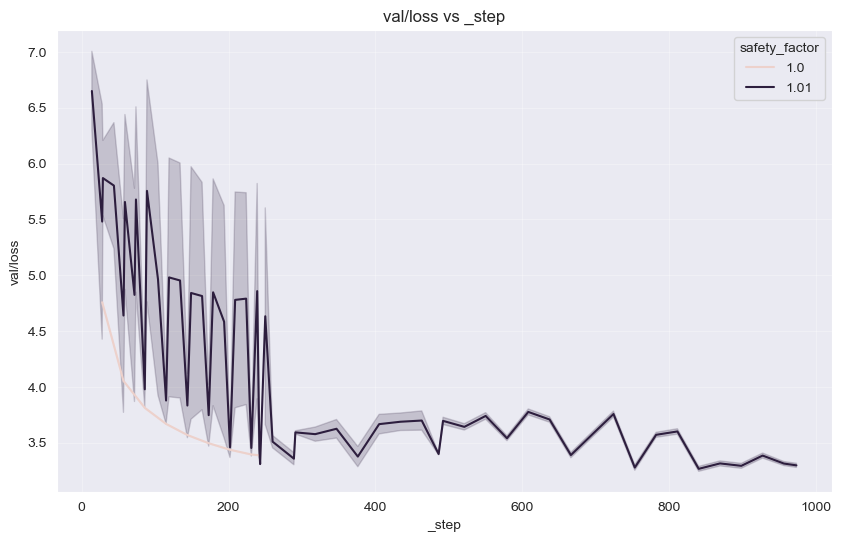

In [12]:
# 1. Load Data
df = load_data()

# 2. Find the REAL name for loss
find_col(df, "loss")

# 3. Plot using the CORRECT name found above
# Replace 'val/loss' with whatever the print statement above gave you
plot_fast(df, x_col="_step", y_col="val/loss", hue_col="safety_factor")

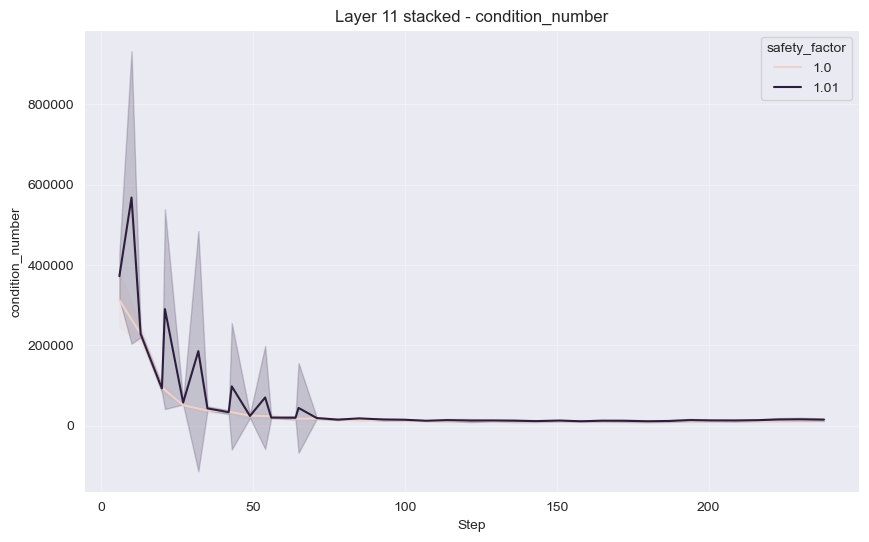

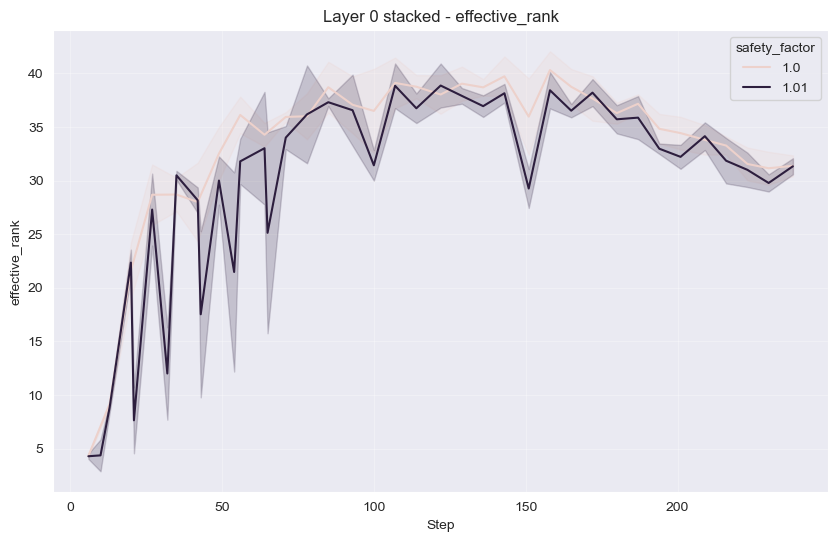

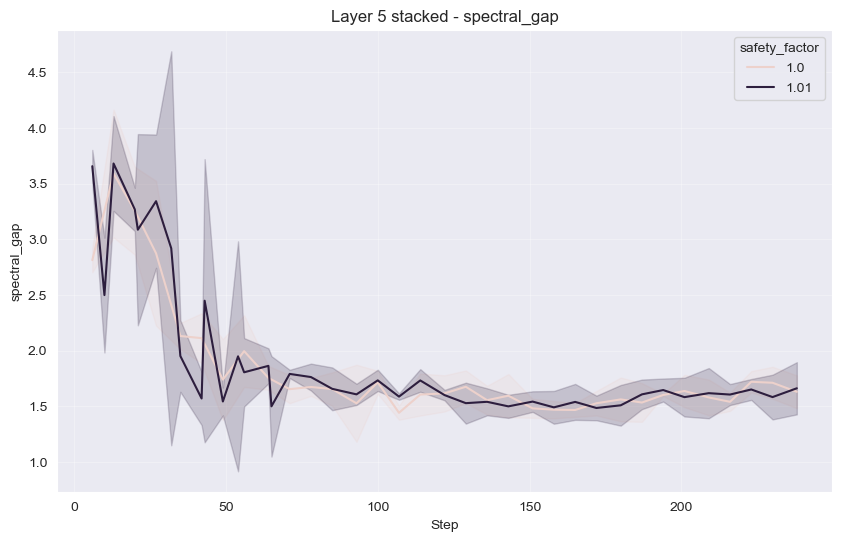

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load your downloaded data
# Ensure you ran the master_downloader.py script first!
df = pd.read_csv("./data/master_project_data.csv", low_memory=False)

# 2. Define the Universal Plotter
def plot_fast(df, layer, matrix, metric, param_name="safety_factor"):
    col_name = f"svd/update_layer{layer}_{matrix}/{metric}"

    plt.figure(figsize=(10, 6))

    # Seaborn does all the math (Mean, Std Dev, Confidence Interval) for you
    sns.lineplot(
        data=df,
        x="_step",
        y=col_name,
        hue=param_name,
        errorbar="sd"
    )

    plt.title(f"Layer {layer} {matrix} - {metric}")
    plt.ylabel(metric)
    plt.xlabel("Step")
    plt.grid(True, alpha=0.3)
    plt.show()

# 3. Generate your 3 plots instantly
plot_fast(df, layer=11, matrix="stacked", metric="condition_number")
plot_fast(df, layer=0,  matrix="stacked", metric="effective_rank")
plot_fast(df, layer=5,  matrix="stacked", metric="spectral_gap")